In [1]:
import pandas as pd
from datetime import datetime
from osgeo import gdal
import numpy as np
import subprocess
import glob
# from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from dateutil.parser import parse
# from tensorflow import keras 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
from collections import Counter

In [2]:
train_labels = pd.read_csv("train_labels.csv")
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')
test_labels = pd.read_csv("submission_format.csv")

In [3]:
train_labels["datetime_dt"]= pd.to_datetime(train_labels["datetime"])

In [4]:
train_labels.groupby("grid_id").size().sort_values(ascending=False).head()

grid_id
3S31A    1047
PG3MI    1042
E5P9N    1040
ZZ8JF    1038
QJHW4    1036
dtype: int64

<AxesSubplot:>

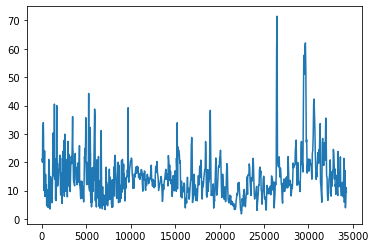

In [5]:
train_labels[train_labels["grid_id"]=="PG3MI"]["value"].plot()

In [6]:
train_labels

,datetime,grid_id,value,datetime_dt
0,2018-02-01T08:00:00Z,3S31A,11.400000,2018-02-01 08:00:00+00:00
1,2018-02-01T08:00:00Z,A2FBI,17.000000,2018-02-01 08:00:00+00:00
2,2018-02-01T08:00:00Z,DJN0F,11.100000,2018-02-01 08:00:00+00:00
3,2018-02-01T08:00:00Z,E5P9N,22.100000,2018-02-01 08:00:00+00:00
4,2018-02-01T08:00:00Z,FRITQ,29.800000,2018-02-01 08:00:00+00:00
...,...,...,...,...
34307,2020-12-31T18:30:00Z,P8JA5,368.611111,2020-12-31 18:30:00+00:00
34308,2020-12-31T18:30:00Z,PW0JT,294.425000,2020-12-31 18:30:00+00:00
34309,2020-12-31T18:30:00Z,VXNN3,224.857143,2020-12-31 18:30:00+00:00
34310,2020-12-31T18:30:00Z,VYH7U,287.000000,2020-12-31 18:30:00+00:00


In [7]:
satellite_metadata.head()

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00


In [8]:
import glob
len(glob.glob("train/maiac/*/*.hdf"))


all_files= glob.glob("train/maiac/*/*.hdf")

In [9]:
all_data = []
def get_all_data_for_loci(ds,granule_id,parellel = False):
    each = {}
    metadata = ds.GetMetadata()
    for i in range(len(ds.GetSubDatasets())):
        raster = gdal.Open(ds.GetSubDatasets()[i][0]) #grid5km:cosSZA features only
        each_raster = raster.GetMetadata()

        long_name = each_raster["long_name"]

         
        all_rasters = []
        if(parellel):
            listi = list(range(int(raster.GetMetadata()["ADDITIONALLAYERS"])))
            
            N = pool.imap(partial(rast_each_info, rasteri=raster), listi)
            
            print(N)
        else:
            for j in range(int(raster.GetMetadata()["ADDITIONALLAYERS"])):
                try:
                    band = raster.GetRasterBand(j+1)
                    band_arr = band.ReadAsArray()
                    all_rasters.append(band_arr.tolist())
                except:
                    pass
            each[long_name] = all_rasters
    
    each_data_f = {'file':granule_id,'metadata':metadata,'data':each}
    return each_data_f
#     with open("../processed2/"+granule_id +'.pickle', 'wb') as handle:
#         pickle.dump(each_data_f, handle)
#     with open("../processed2/"+granule_id + ".json", "w") as outfile:
#         orjson.dumps(each_data_f, outfile)
    

In [10]:
def get_all_data_for_loci_specific(ds,granule_id,parellel = False):
    each = {}
    s = ds.GetSubDatasets()
    raster = gdal.Open(s[0][0]) #grid5km:cosSZA features only
    each_raster = raster.GetMetadata()
    long_name = each_raster["long_name"]

    all_rasters = []
    if(parellel):
        listi = list(range(int(raster.GetMetadata()["ADDITIONALLAYERS"])))

        N = pool.imap(partial(rast_each_info, rasteri=raster), listi)

        print(N)
    else:
        for j in range(int(raster.GetMetadata()["ADDITIONALLAYERS"])):
            try:
                band = raster.GetRasterBand(j+1)
                band_arr = band.ReadAsArray()
                all_rasters.append(band_arr)
            except:
                pass
        each[long_name] = all_rasters
        
    raster = gdal.Open(s[1][0]) #grid5km:cosSZA features only
    each_raster = raster.GetMetadata()
    long_name = each_raster["long_name"]
    all_rasters2 = []
    if(parellel):
        listi = list(range(int(raster.GetMetadata()["ADDITIONALLAYERS"])))

        N = pool.imap(partial(rast_each_info, rasteri=raster), listi)

        print(N)
    else:
        for j in range(int(raster.GetMetadata()["ADDITIONALLAYERS"])):
            try:
                band = raster.GetRasterBand(j+1)
                band_arr = band.ReadAsArray()
                all_rasters2.append(band_arr)
            except:
                pass
        each[long_name] = all_rasters2

    each_data_f = {'file':granule_id,'data':each}
    del ds
    return each_data_f

In [11]:
# import pprofile
# profiler = pprofile.Profile()
# with profiler:
#     fetch_subset('20180308T031500_maiac_tpe_0.hdf')
# # Process profile content: generate a cachegrind file and send it to user.

# # You can also write the result to the console:
# profiler.print_stats()

In [12]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

def format_file_path(granule_id):
    year = granule_id[:4]
    res = 'train/maiac/'+year+'/'+granule_id
    return res

def fetch_subset(granule_id):
    formatted = format_file_path(granule_id)
    ds = load_data( formatted)
    return get_all_data_for_loci_specific(ds,granule_id)

In [13]:
granule_id = '20180308T031500_maiac_tpe_0.hdf'
formatted = format_file_path(granule_id)
ds = load_data( formatted)

In [14]:
# import pprofile
# profiler = pprofile.Profile()
# with profiler:
#     get_all_data_for_loci_specific(ds,granule_id)
# # Process profile content: generate a cachegrind file and send it to user.

# # You can also write the result to the console:
# profiler.print_stats()

In [15]:
%%time
res = fetch_subset('20180308T031500_maiac_tpe_0.hdf')

CPU times: user 204 ms, sys: 19 ms, total: 223 ms
Wall time: 227 ms


In [16]:
# dir(res["data"]['AOD at 0.47 micron'][0].ReadRaster())()

In [17]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [18]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"
    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parse(datetime)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

In [19]:
def fetch_training_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split)
    counter = 0
    features = None
    for i in range(len(sat_met)):
        counter+=1
        granule_id = sat_met.iloc[i]['granule_id']

        subset = fetch_subset(granule_id)
        if features is None:
            features = subset
        else:
            features+=subset
    return features/counter

In [20]:
def fetch_training_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split)
    counter = 0
    features = None
    granule_id_loc = []
    for i in range(len(sat_met)):
        counter+=1
        granule_id = sat_met.iloc[i]['granule_id']
        granule_id_loc.append(granule_id)
    return granule_id_loc
        
#         subset = fetch_subset(granule_id)
        

In [21]:
from multiprocessing import Pool
import tqdm

# features = []
split = "train"
# pool = Pool(processes=16)


In [22]:
tasks = list(zip(train_labels["grid_id"],train_labels["datetime"]))
tasks[:5]

[('3S31A', '2018-02-01T08:00:00Z'),
 ('A2FBI', '2018-02-01T08:00:00Z'),
 ('DJN0F', '2018-02-01T08:00:00Z'),
 ('E5P9N', '2018-02-01T08:00:00Z'),
 ('FRITQ', '2018-02-01T08:00:00Z')]

In [23]:
len(tasks)

34312

In [24]:
def get_ds_loc(i):
    feature = fetch_training_features(i[0], i[1], split)
    return feature

In [25]:
get_ds_loc(tasks[5])

['20180201T191000_maiac_la_0.hdf']

In [26]:
from multiprocessing import get_context

pool = get_context("fork").Pool(8)
# pool = Pool(processes=8)

all_files_d = []
for x in tqdm.tqdm(pool.imap_unordered(get_ds_loc, tasks), total=len(tasks)):
    all_files_d.append(x)

100%|██████████| 34312/34312 [00:21<00:00, 1605.58it/s]


In [27]:
len(all_files_d)

34312

In [28]:
all_files_d[0]

['20180201T191000_maiac_la_0.hdf']

In [29]:
data_to_loc = {"|".join(i):j for i,j in zip(tasks,all_files_d)}

In [30]:
all_files_flatten = [j for i in all_files_d for j in i ]

In [31]:
all_files_flatten = list(set(all_files_flatten))

In [32]:
len(all_files_flatten)

4234

In [33]:
def get_ds_loc(i):
    feature = fetch_training_features(i[0], i[1], split)
    print(i)
    return feature

In [34]:
get_ds_loc(tasks[5])

('H96P6', '2018-02-01T08:00:00Z')


['20180201T191000_maiac_la_0.hdf']

In [35]:
%%time
res = fetch_subset('20180308T031500_maiac_tpe_0.hdf')

CPU times: user 176 ms, sys: 12.1 ms, total: 188 ms
Wall time: 196 ms


In [36]:
res["data"].keys()

dict_keys(['AOD at 0.47 micron', 'AOD at 0.55 micron'])

In [37]:
from multiprocessing import get_context
p = get_context("fork").Pool(8)
all_files_d_100 = []
for i in tqdm.tqdm(all_files_flatten[:100]):
    x = fetch_subset(i)
    all_files_d_100.append(x)

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


In [38]:
all_files_d_100_dict= {i["file"]:i["data"] for i in all_files_d_100 }

In [39]:
del all_files_d_100

In [40]:
len(all_files_d_100_dict)

100

In [41]:
data_to_loc['3S31A|2018-02-01T08:00:00Z']

['20180201T191000_maiac_la_0.hdf']

In [42]:
# 3S31A

In [43]:
data_to_y = {}

In [44]:
# [all_files_d_100_dict[data_to_loc[i[1]+"|"+i[0]][0]],j]

In [45]:
all_files_flatten[0]

'20180710T065500_maiac_dl_0.hdf'

In [46]:
dt = []
loc = []
for i in train_labels.values:
    try:
        dt.append( [all_files_d_100_dict[data_to_loc[i[1]+"|"+i[0]][0]],i[2]] )
        loc.append(i[1])
    except:
        pass


In [47]:
# loc

In [48]:
x = []
for each in dt:
    x.append(np.array([i for j in each[0].values() for i in j[:3]]))

In [49]:
# x[0]

In [50]:
# x = [np.array(i) for i in x]

In [51]:
y = [ i[1] for i in dt]

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
x_one = enc.fit_transform(np.array(loc).reshape(-1, 1)).toarray()

In [54]:
# for i in train_test_split(x, y,loc, test_size=0.2, random_state=1):
#     print(i[0])

In [55]:
X_train, X_test, y_train, y_test, loc_train,loc_test = train_test_split(x, y,x_one, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val, loc_train, loc_val  = train_test_split(X_train, y_train,loc_train, test_size=0.25, random_state=1) 

In [56]:
print(X_train[0].max())

1992


In [57]:
max([i.max() for i in x])

4089

In [58]:
batch_size = 8
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [59]:
print(f"Train Data: {len(X_train)}")
print(f"Validation Data: {len(X_val)}")
print(f"Test Data: {len(X_test)}")

Train Data: 538
Validation Data: 180
Test Data: 180


In [60]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [61]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


In [62]:
class SatelliteDataset(Dataset):
    def __init__(self, file_list, y_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.y_list = y_list

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img = self.file_list[idx]
        img = np.where(img <0 , 0, img)/4089
        img_transformed = self.transform(img)


        label = self.y_list[idx]
        img_transformed= img_transformed.reshape((6, 1200, 1200))
        return img_transformed, label

In [63]:
train_data = SatelliteDataset(X_train, y_train, transform=train_transforms)
valid_data = SatelliteDataset(X_val, y_val, transform=test_transforms)
test_data = SatelliteDataset(X_test, y_test, transform=test_transforms)

In [64]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)


In [133]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim+54),
            nn.Linear(dim+54, 512),
              nn.LeakyReLU(),
            nn.Linear(512, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 32),
            nn.LeakyReLU(),
              nn.Linear(32, 16),
            nn.LeakyReLU(),
              nn.Linear(16, 1),
        )

    def forward(self, img,one_hot):

        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        x = torch.cat((x, one_hot), dim=1)
        x = self.mlp_head(x)
        return x

In [144]:
import torch
# from vit_pytorch import ViT

v = ViT(
    image_size = 1200,
    patch_size = 30,
    num_classes = 1,
    channels = 6,
    dim = 1024,
    depth = 3,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(v.parameters(), lr=1e-4)



In [145]:
img = torch.randn(8, 6, 1200, 1200).float()
img.dtype

torch.float32

In [136]:
one_hot_example = torch.from_numpy(loc_train[0:8].reshape(8,-1)).float()

In [137]:
one_hot_example.dtype

torch.float32

In [162]:
%%time
preds = v(img,one_hot_example) # (1, 1000)

CPU times: user 18 s, sys: 3.04 s, total: 21.1 s
Wall time: 16.9 s


In [163]:
y_train = np.array(y_train)

In [164]:
y_train_p = torch.from_numpy(y_train[:8].reshape(8,-1))

In [165]:
loss = loss_function(y_train_p, preds)
loss

tensor(21.9037, dtype=torch.float64, grad_fn=<L1LossBackward0>)

In [158]:
optimizer.zero_grad()

In [159]:
loss.backward()

In [160]:
optimizer.step()

In [161]:
loss

tensor(22.0396, dtype=torch.float64, grad_fn=<L1LossBackward0>)

In [ ]:
acc = (preds.argmax(dim=1) == label).float().mean()

In [166]:
preds

tensor([[-0.0370],
        [-0.0320],
        [-0.0303],
        [-0.0327],
        [-0.0226],
        [-0.0271],
        [-0.0314],
        [-0.0308]], grad_fn=<AddmmBackward0>)

In [ ]:
y_train_p

In [65]:
# train_data[0][0]

In [319]:

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.2):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)
        return x

In [320]:

class DeepViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 6, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(dim),
#             nn.Linear(dim, num_classes)
#         )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 512),
              nn.LeakyReLU(),
            nn.Linear(512, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 64),
              nn.LeakyReLU(),
              nn.Linear(64, 32),
            nn.LeakyReLU(),
              nn.Linear(32, 16),
            nn.LeakyReLU(),
              nn.Linear(16, 1),
        )
    
    def forward(self, img,one_hot):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)


        x = torch.cat((x, one_hot), dim=1)
        x = self.mlp_head(x)
#         print(x.shape)
        return x
    
    

In [321]:
import torch

In [322]:
one_hot_example = torch.from_numpy(loc_train[0].reshape(1,-1))
one_hot_example

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)

In [323]:
# torch.from_numpy(x_one[0].reshape(1,-1))

In [324]:
# preds.shape

In [325]:
# torch.cat((preds,torch.from_numpy(x_one[0].reshape(1,-1))),dim=1)

In [326]:
v = DeepViT(
    image_size = 1200,
    patch_size = 30,
    num_classes = 1,
    dim = 1024,
    depth = 3,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [327]:
img = torch.randn(8, 6, 1200, 1200)

In [328]:
one_hot_example = torch.from_numpy(loc_train[8*i:(i+1)*8].reshape(8,-1))

In [329]:
one_hot_example.shape

torch.Size([8, 54])

In [330]:
# some = train_data[0][0].reshape((1, 6, 1200, 1200))

In [ ]:
v(img.float(),one_hot_example)

In [305]:
torch.from_numpy(loc_train[64*i:(i+1)*64].reshape(64,-1)).shape

torch.Size([64, 54])

In [295]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(v.parameters(), lr=1e-4)


In [302]:
for epoch in range(0, 1): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
        one_hot_example = torch.from_numpy(loc_train[64*i:(i+1)*64]
        print(len(data[0]))
        break
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = mlp(inputs)
      
        # Compute loss
        loss = loss_function(outputs, targets)
      
        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
            current_loss = 0.0

  # Process is complete.
print('Training process has finished.')

Starting epoch 1
64
Training process has finished.


In [292]:
%%time
preds = v(some.float(),one_hot_example)

CPU times: user 3.04 s, sys: 797 ms, total: 3.83 s
Wall time: 2.75 s


In [293]:
# criterion = nn.MSELoss()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


In [294]:
preds

tensor([[0.2256]], grad_fn=<AddmmBackward0>)

In [118]:
id_l = list(set(train_labels["grid_id"]))

In [53]:
x_one[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [122]:
# '3S31A|2018-02-01T08:00:00Z' =='3S31A|2018-02-01T08:00:00Z'

In [123]:
train_labels

,datetime,grid_id,value
0,2018-02-01T08:00:00Z,3S31A,11.400000
1,2018-02-01T08:00:00Z,A2FBI,17.000000
2,2018-02-01T08:00:00Z,DJN0F,11.100000
3,2018-02-01T08:00:00Z,E5P9N,22.100000
4,2018-02-01T08:00:00Z,FRITQ,29.800000
...,...,...,...
34307,2020-12-31T18:30:00Z,P8JA5,368.611111
34308,2020-12-31T18:30:00Z,PW0JT,294.425000
34309,2020-12-31T18:30:00Z,VXNN3,224.857143
34310,2020-12-31T18:30:00Z,VYH7U,287.000000


In [51]:
list(data_to_loc.keys())[0]

'3S31A|2018-02-01T08:00:00Z'

In [60]:
a = all_files_d_100_dict['20180201T191000_maiac_la_0.hdf']['AOD at 0.47 micron']

In [52]:
'3S31A|2018-02-01T08:00:00Z'.split("|")

['3S31A', '2018-02-01T08:00:00Z']

In [65]:
np.where(a[0] <0 , 0, a[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [59]:
np.bincount(a)

ValueError: object too deep for desired array

In [44]:
len(all_files_d_100)

4234

In [45]:
all_47 = []
all_55 = []
# 'AOD at 0.55 micron'
for i in all_files_d_100:
    for j in i["data"]['AOD at 0.47 micron']:
        all_47.append(j)
    for j in i["data"]['AOD at 0.55 micron']:
        all_55.append(j)
        

In [60]:
len(all_47),len(all_55)

(15268, 15268)

In [69]:
1+1

2

In [84]:
np.count_nonzero(i < 0)

1439995

In [85]:
1200*1200

1440000

In [70]:
i

array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
       [-28672, -28672, -28672, ..., -28672, -28672, -28672],
       [-28672, -28672, -28672, ..., -28672, -28672, -28672],
       ...,
       [-28672, -28672, -28672, ..., -28672,    276,    280],
       [-28672, -28672, -28672, ..., -28672,    252,    254],
       [-28672, -28672, -28672, ..., -28672, -28672,    340]], dtype=int16)

In [88]:
all_47_f = [ i for i in all_47 if(np.count_nonzero(i < 0) <1439995 )]
all_55_f = [ i for i in all_55 if(np.count_nonzero(i < 0) <1439995 )]

In [112]:
import pickle

In [113]:
with open('all_47_f','wb') as f: pickle.dump(all_47_f, f)

In [114]:
with open('all_55_f','wb') as f: pickle.dump(all_55_f, f)

In [111]:
1+1

2

# 

In [89]:
len(all_47_f),len(all_55_f)

(14316, 14316)

In [91]:
ls

PyTorch-VAE/         grid_metadata.csv            submission_format.csv
aws/                 onstart.log                  test/
bash.ipynb           onstart.sh                   train/
data_handling.ipynb  pm25_satellite_metadata.csv  train_labels.csv


In [106]:
import sys
sys.path.insert(0,'./PyTorch-VAE/')

In [109]:

import os
import yaml
import argparse
import numpy as np
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin


ModuleNotFoundError: No module named 'models'

In [ ]:
1+1
    

In [61]:
all_47 = 

array([[-28672, -28672, -28672, ..., -28672, -28672,    111],
       [-28672, -28672, -28672, ..., -28672, -28672,    101],
       [-28672, -28672, -28672, ..., -28672,     91,     91],
       ...,
       [-28672, -28672, -28672, ...,     68,     66,     79],
       [-28672, -28672, -28672, ...,     56,     55,     62],
       [-28672, -28672, -28672, ...,     48,     48,     53]], dtype=int16)

In [56]:
all_files_d_100[0]["data"]#['AOD at 0.47 micron'][0].shape

{'AOD at 0.47 micron': [array([[-28672, -28672, -28672, ..., -28672, -28672,    111],
         [-28672, -28672, -28672, ..., -28672, -28672,    101],
         [-28672, -28672, -28672, ..., -28672,     91,     91],
         ...,
         [-28672, -28672, -28672, ...,     68,     66,     79],
         [-28672, -28672, -28672, ...,     56,     55,     62],
         [-28672, -28672, -28672, ...,     48,     48,     53]], dtype=int16),
  array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672, -28672, ..., -28672, -28672, -28672],
         ...,
         [-28672, -28672, -28672, ...,    175,    168,    173],
         [-28672, -28672, -28672, ...,    189,    178,    173],
         [-28672, -28672, -28672, ...,    177,    163,    154]], dtype=int16),
  array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672

In [38]:
import warnings
warnings.simplefilter("ignore")

In [50]:
len(set(train_labels["grid_id"]))

54

In [51]:
satellite_metadata.head()

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00


In [54]:
data_to_loc['3S31A|2018-02-01T08:00:00Z']

['20180201T191000_maiac_la_0.hdf']